This notebook allows to reproduce the paper synthetic results. First, we create a synthetic population with different disease expression. Then, we enforce missingness following three scenario of clinical presence, i.e. the interaction between patient and the healthcare system:
- (Mis)-informed collection
- Limited access to quality care
- Confirmation bias

In [1]:
from utils import *
import numpy as np

### Generate data

First, we create the data from three gaussian: one for positives and two for negatives (one for the minority and one for the majority)

In [2]:
def generate_data_linear_shift(majority_size, ratio, class_balance = 0.5):
    """
        Generate data with a shift in the linear separation for the minority
        Negative are the same but not positive

        Args:
            majority_size (int): Number points for majority
            ratio (float): Ratio for minority (0.1 = 1 in minority for 10 in majority)
            class_balance (float, optional): Balance between class. Default 0.5.
    """
    np.random.seed(0)

    majority_pos = 0.25 * np.random.randn(int(majority_size * class_balance), 2)
    majority_neg = 0.25 * np.random.randn(int(majority_size * (1 - class_balance)), 2)
    majority_pos[:, 0] += 1
    majority = np.concatenate([majority_pos, majority_neg])
    labels_maj = np.concatenate([np.full(len(majority_pos), True), np.full(len(majority_neg), False)])

    minority_pos = 0.25 * np.random.randn(int(majority_size * ratio * class_balance), 2)
    minority_neg = 0.25 * np.random.randn(int(majority_size * ratio * (1 - class_balance)), 2)
    minority_pos[:, 1] += 1
    minority = np.concatenate([minority_pos, minority_neg])
    labels_min = np.concatenate([np.full(len(minority_pos), True), np.full(len(minority_neg), False)])

    concatenation = np.concatenate([majority, minority])
    labels = np.concatenate([labels_maj, labels_min])
    protected =  np.concatenate([np.full(len(labels_maj), False), np.full(len(labels_min), True)])

    sort = np.arange(len(concatenation))
    np.random.shuffle(sort)
    return concatenation[sort], labels[sort], protected[sort]

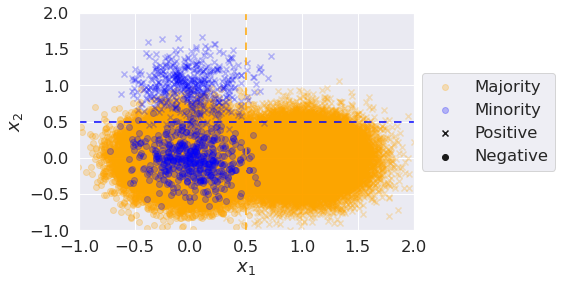

In [3]:
data, labels, protected = generate_data_linear_shift(majority_size = 100000, ratio = 0.01)
display_data(data, labels, protected)

### Mis-informed collection

In [4]:
# Remove data
p = (data[:, 1] > 0.5).astype(float) # All above threshold
total = p.sum()
selection = np.random.choice(len(data), size = int(total * 0.5), replace = False, p = p / total) # 50 % missing
missing = data.copy()
missing[selection, 0] = np.nan

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


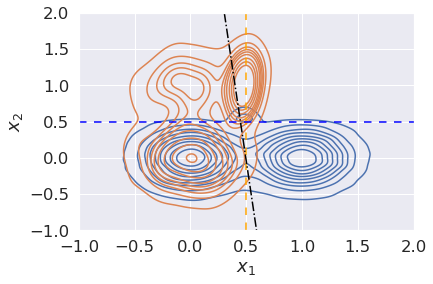

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


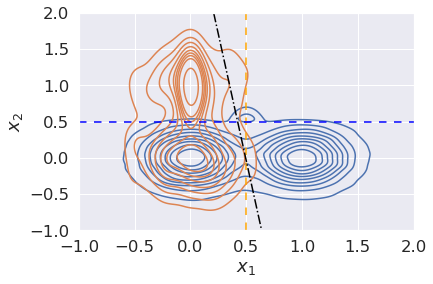

In [5]:
# Variable for results
min_perf, maj_perf, tot_perf, min_rocs = {}, {}, {}, {}

for imputation in ['Population', 'Group']:
    ## Imputation
    imputed = impute_data(missing, protected, strategy = imputation)

    ## Modelling
    min_perf[imputation], maj_perf[imputation], tot_perf[imputation], min_rocs[imputation], coefs = cross_validation(imputed, labels, protected)

    ## Display
    display_data(imputed, labels, protected, distribution = True, legend = False)
    plt.axline((0, np.mean(coefs, 0)[0]), slope = np.mean(coefs, 0)[1], c = 'black', ls = '-.')
    plt.show()

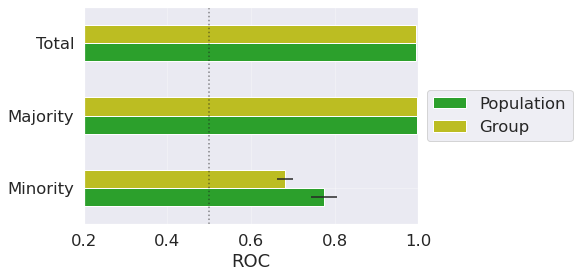

In [6]:
display_result(min_perf, maj_perf, tot_perf)

### Limited access to quality care

In [7]:
# Remove data
p = (protected == 1).astype(float) # All minority
total = p.sum()
selection = np.random.choice(len(data), size = int(total * 0.5), replace = False, p = p / total) # 50 % missing
missing = data.copy()
missing[selection, 0] = np.nan

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


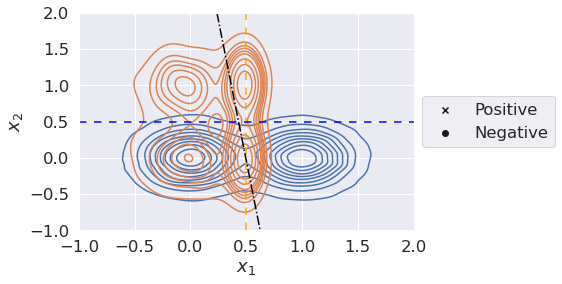

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


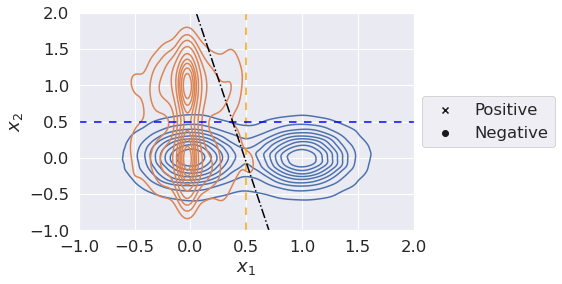

In [8]:
# Variable for results
min_perf, maj_perf, tot_perf, min_rocs = {}, {}, {}, {}

for imputation in ['Population', 'Group']:
    ## Imputation
    imputed = impute_data(missing, protected, strategy = imputation)

    ## Modelling
    min_perf[imputation], maj_perf[imputation], tot_perf[imputation], min_rocs[imputation], coefs = cross_validation(imputed, labels, protected)

    ## Display
    display_data(imputed, labels, protected, distribution = True, legend = False)
    plt.axline((0, np.mean(coefs, 0)[0]), slope = np.mean(coefs, 0)[1], c = 'black', ls = '-.')
    plt.show()

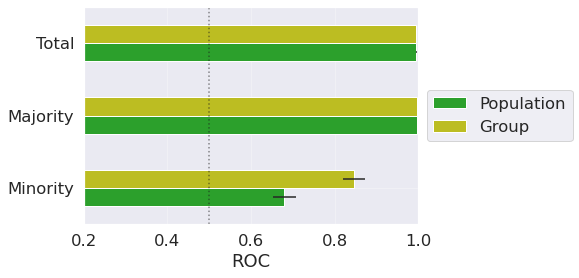

In [9]:
display_result(min_perf, maj_perf, tot_perf)

### Confirmation bias

In [10]:
# Remove data
p = (labels == 0).astype(float) # All negatives
total = p.sum()
selection = np.random.choice(len(data), size = int(total * 0.5), replace = False, p = p / total)
missing = data.copy()
missing[selection, 0] = np.nan

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


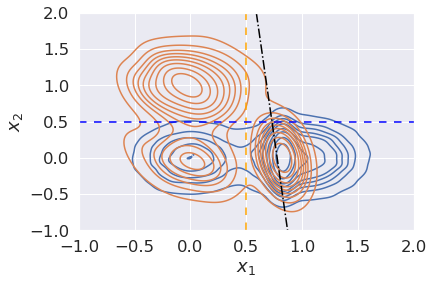

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


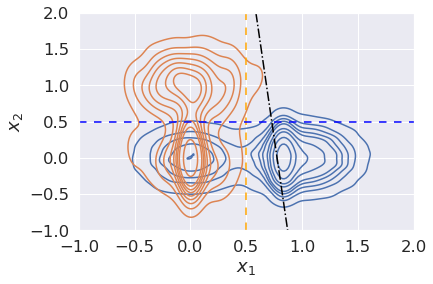

In [11]:
# Variable for results
min_perf, maj_perf, tot_perf, min_rocs = {}, {}, {}, {}

for imputation in ['Population', 'Group']:
    ## Imputation
    imputed = impute_data(missing, protected, strategy = imputation)

    ## Modelling
    min_perf[imputation], maj_perf[imputation], tot_perf[imputation], min_rocs[imputation], coefs = cross_validation(imputed, labels, protected)

    ## Display
    display_data(imputed, labels, protected, distribution = True, legend = False)
    plt.axline((0, np.mean(coefs, 0)[0]), slope = np.mean(coefs, 0)[1], c = 'black', ls = '-.')
    plt.show()

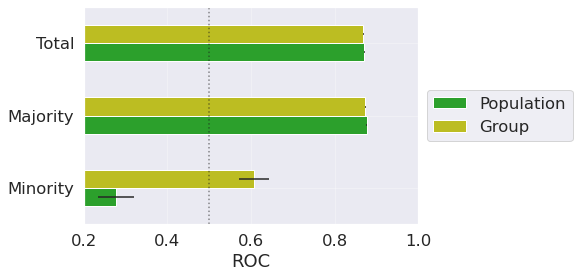

In [12]:
display_result(min_perf, maj_perf, tot_perf)

----------

# Distirbution variation

0


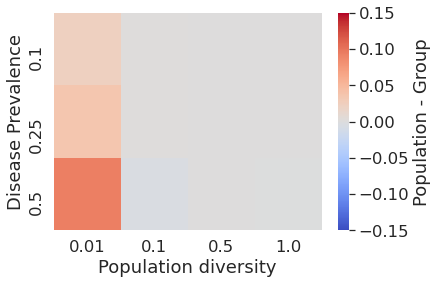

1


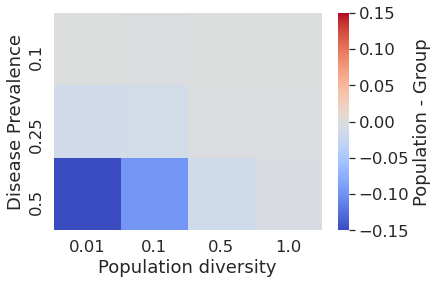

2


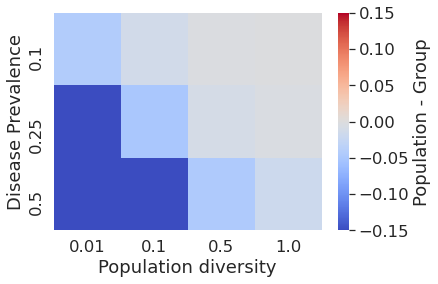

In [13]:
min_diff = {}
for ratio in [0.01, 0.1, 0.5, 1]:
    for disease_ratio in [0.1, 0.25, 0.5]:
        # Create data with characteristics
        data, labels, protected = generate_data_linear_shift(majority_size = 100000, ratio = ratio, class_balance = disease_ratio)

        for missing_strategy in range(3):
            # Remove data
            if missing_strategy == 0:
                p = (data[:, 1] > 0.5).astype(float)
            elif missing_strategy == 1:
                p = (protected == 1).astype(float)
            else:
                p = (labels == 0).astype(float) # All negatives
            total = p.sum()
            selection = np.random.choice(len(data), size = int(total * 0.5), replace = False, p = p / total)
            missing = data.copy()
            missing[selection, 0] = np.nan

            min_perf = {}
            for imputation_strategy in ['Population', 'Group']:
                imputed = impute_data(missing, protected, strategy = imputation_strategy)
                min_perf[imputation_strategy], _, _, _, _= cross_validation(imputed, labels, protected)

            if missing_strategy not in min_diff:
                min_diff[missing_strategy] = {}
            if ratio not in min_diff[missing_strategy]:
                min_diff[missing_strategy][ratio] = {}
            if disease_ratio not in min_diff[missing_strategy][ratio]:
                min_diff[missing_strategy][ratio][disease_ratio] = {}

            min_diff[missing_strategy][ratio][disease_ratio] = np.mean(np.array(min_perf['Population']) - np.array(min_perf['Group']))

for missing in min_diff:
    print(missing)
    set = pd.DataFrame(min_diff[missing])
    ax = sns.heatmap(set, cbar_kws = {'label': 'Population - Group'}, vmin = -0.15, vmax = 0.15, cmap = 'coolwarm')
    plt.xlabel('Population diversity')
    plt.ylabel('Disease Prevalence')
    plt.show()